### 1.0 Imports

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
from math import radians, cos, sin, asin, sqrt #using this for calculating the distance between points

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [457]:
#load trees data we exported in the prior step
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data we exported in the prior step
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

#### 2.1 Precipitation Data

After testing this out with climate normals data, I only ended up with 3 useful stations for data. So while I was excited to have the 'normals' which is averages over a 15-20 year period, I want to now test pulling in some other data I found.
\
\
The Community Collaborative Rain, Hail, & Snow Network has some great tools to access data. Unfortunately, it is only for the 2022 calendar year. I don't love that, but I think it will give me more useful datapoints to and make the analysis more valuable.
\
\
When pulling this data, I filtered down to all available weather stations in King County, Washington, which includes the Seattle proper. Upon further testing, I realized how 'collaborative' this data really is - relying on manual input. Because of this there is a lot of incomplete data we'll need to work through. I don't love this, and it comes back to me not being able to find a solid data source with long-term, complete data. I think it poses a fun and interesting challenge on how to impute information to make this data useable. My initial thoughts are to use a few of the more complete stations, calculate some "normals" on daily averages, and use them to beef up the others stations's data. This won't be perfect because I won't know which time of year has missing data (rainy or dry season?), but it wil have to do!
\
\
https://merbgai.cocorahs.org/Stations/ListStations.aspx

In [458]:
prcp_22 = pd.read_excel('../data/precip_2022.xlsx', sheet_name=0)
print(prcp_22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB
None


In [459]:
prcp_22.head(3)

,Station Number,Station Name,Daily Precipitation Sum MM,Multi-Day Precipitation mm,Total Precipitation mm,Daily Snow Sum cm,# of Reports,Latitude,Longitude,Multi-Day Overlap Warning
0,WA-KG-3,Lake Forest Park 0.4 W,1111.2,NaN,1111.2,0.0,365,47.763558,-122.293917,NaN
1,WA-KG-4,Renton 3.2 E,149.1,NaN,149.1,0.0,21,47.484508,-122.127169,NaN
2,WA-KG-5,Mercer Island 1.5 NW,1043.4,NaN,1043.4,8.4,365,47.585900,-122.250900,NaN


**Observations**
\
\
The 'Total Precipitation mm' column should be the combination of the dailiy and multi-day column and the field we use. There is no multi-day column for snow, so that will be the column we can use for snow data.
\
\
I will need to confirm latitude & longitude data is complete. I also want to do some renaming of columns to make them a little more straight forward. So far what I've seen from the data, I don't need to worry about the multi-day 'warning', as I believe it is cumulative and not duplicative. I also think I'll convert the cm of snow into mm to match the precipitation. Go metric system!

### 3.0 Explore and Cleanup PRCP data

In [460]:
prcp_22.shape

(73, 10)

In [461]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB


#### 3.0.1 Rename Fields

In [462]:
#Now I want to go through the precipitation data and rename the fields to be more Python friendly
prcp_22.rename(columns ={'Station Number': 'station_id', 'Station Name': 'station_name', 'Daily Precipitation Sum MM': 'daily_prcp_mm',
                         'Multi-Day Precipitation mm': 'multi_day_prcp_mm', 'Total Precipitation mm': 'total_prcp_mm',
                         'Daily Snow Sum cm': 'daily_snow_cm', '# of Reports': 'reports_#', 'Latitude': 'lat_prcp',
                         'Longitude': 'long_prcp', 'Multi-Day Overlap Warning': 'md_overlap'}, inplace=True)

#verify the names stuck
prcp_22.columns

Index(['station_id', 'station_name', 'daily_prcp_mm', 'multi_day_prcp_mm',
       'total_prcp_mm', 'daily_snow_cm', 'reports_#', 'lat_prcp', 'long_prcp',
       'md_overlap'],
      dtype='object')

#### 3.0.2 Missing Values

In [463]:
#view the % of rows which are missing data in each field
prcp_22.isnull().sum() / prcp_22.shape[0] * 100

station_id            0.000000
station_name          0.000000
daily_prcp_mm         0.000000
multi_day_prcp_mm    36.986301
total_prcp_mm         0.000000
daily_snow_cm         0.000000
reports_#             0.000000
lat_prcp              0.000000
long_prcp             0.000000
md_overlap           89.041096
dtype: float64

The missing values are both related to the multi-day preciptation, which I would expect to not be 100% complete (it's only used if multi-day entries were made)
For now, I'm actually most curious if the daily+multiday = total, which it should. Before changing or dropping anything, let's make sure those match.

#### 3.0.2.0 Validate the Parts Equal the Whole

In [464]:
# Store fund columns to sum against
prcp_columns = ['daily_prcp_mm', 'multi_day_prcp_mm']

# Find rows where prcp_columns row sum == total
prcp_equ = prcp_22[prcp_columns].sum(axis=1) == prcp_22['total_prcp_mm']

# Store consistent and inconsistent data
consistent_prcp = prcp_22[prcp_equ]
inconsistent_prcp = prcp_22[~prcp_equ]

# Store consistent and inconsistent data
print("Number of inconsistent records: ", inconsistent_prcp.shape[0])

Number of inconsistent records:  18


In [465]:
#What do those records look like? I'm going to look by unique station
inconsistent_prcp[['station_name','daily_prcp_mm','multi_day_prcp_mm','total_prcp_mm']].value_counts()

station_name          daily_prcp_mm  multi_day_prcp_mm  total_prcp_mm
Auburn 8.2 SE         1217.2         67.1               1284.2           1
Bellevue 1.8 W        1073.2         83.6               1156.7           1
Vashon 4.9 SE         373.1          101.6              474.7            1
Sheridan Beach 3.7 S  957.8          37.3               995.2            1
Seattle 4.9 SE        913.1          29.2               942.3            1
Seattle 4.9 NNE       220.0          232.2              452.1            1
Seattle 4.8 NNW       308.4          96.8               405.1            1
Seattle 4.6 NNE       179.1          265.7              444.8            1
Seattle 4.2 SW        931.7          98.6               1030.2           1
Seattle 4.0 NNW       418.1          3.8                421.9            1
Sammamish 3.0 ESE     1167.6         83.6               1251.2           1
Redmond 6.2 ESE       423.2          90.2               513.3            1
Redmond 1.7 N         970.8   

These variances appear to just be rounding, but to be thorough, we will add a new calculated field using the two parts.

#### 3.0.2.1 Re-Calculate Total Column and Drop Old Fields

In [466]:
#Create a new field using daily + multi-day. I'm also filling NaNs with 0 on the multi day in order to add correctly.
prcp_22['prcp_mm_22'] = prcp_22['daily_prcp_mm'] + prcp_22['multi_day_prcp_mm'].fillna(0)

In [467]:
#Rechecking with our new column
prcp_columns = ['daily_prcp_mm', 'multi_day_prcp_mm']
prcp_equ = prcp_22[prcp_columns].sum(axis=1) == prcp_22['prcp_mm_22'] #this time checking against our new column

consistent_prcp = prcp_22[prcp_equ]
inconsistent_prcp = prcp_22[~prcp_equ]

print("Number of inconsistent records: ", inconsistent_prcp.shape[0])

Number of inconsistent records:  0


That's better. Now I'll drop the old total column and daily column, but I will keep the multi_day column, because I think it may come in handy when imputing missing values later.

In [468]:
#drop the two columns
prcp_22.drop(columns=['daily_prcp_mm','total_prcp_mm'], inplace=True)

#print columns
prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'daily_snow_cm',
       'reports_#', 'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22'],
      dtype='object')

#### 3.0.3 Synchronize Precipitation and Snowfall Data

Our data has mm for precipitation, but centimeters for snowfall. We want to convert these to the same units of measurement for furture use.

In [469]:
#Because the metric system is the best, I can easily create a new mm field for snow by multiplying my cm by 10.
prcp_22['snow_mm_22'] = prcp_22['daily_snow_cm']*10

#validate this resulting new column
prcp_22[['daily_snow_cm', 'snow_mm_22']].value_counts()

daily_snow_cm  snow_mm_22
0.0            0.0           37
0.5            5.0            2
2.0            20.0           2
2.8            28.0           2
5.1            51.0           2
3.8            38.0           2
19.0           190.0          1
11.2           112.0          1
13.5           135.0          1
13.7           137.0          1
17.8           178.0          1
19.6           196.0          1
10.2           102.0          1
19.8           198.0          1
20.0           200.0          1
20.3           203.0          1
63.5           635.0          1
10.4           104.0          1
8.1            81.0           1
8.9            89.0           1
8.4            84.0           1
0.2            2.0            1
7.1            71.0           1
6.6            66.0           1
5.6            56.0           1
4.8            48.0           1
3.5            35.0           1
2.5            25.0           1
1.3            13.0           1
1.0            10.0           1
0.8           

In [470]:
#This looks good so I'll drop the original field
prcp_22.drop(columns=['daily_snow_cm'], inplace=True)

prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'reports_#',
       'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22', 'snow_mm_22'],
      dtype='object')

#### 3.0.4 Review Distribution of Rainfall and Snow Data

I know from reviewing the data source that it relies on manual data entry, but let's check out how widespread the distrubtion of the data is.

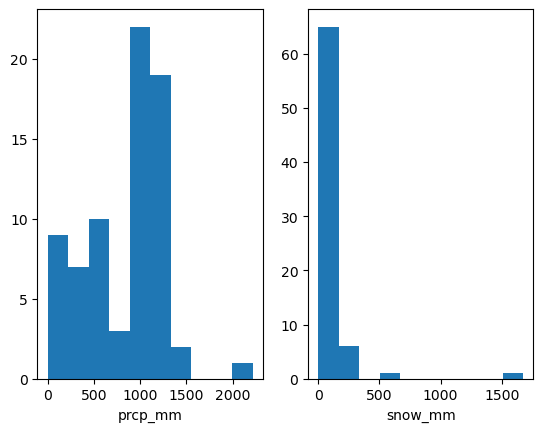

In [471]:
fig, ax = plt.subplots(1,2, squeeze=False)

ax[0,0].hist(prcp_22['prcp_mm_22'])
ax[0,1].hist(prcp_22['snow_mm_22'])
ax[0,0].set_xlabel('prcp_mm')
ax[0,1].set_xlabel('snow_mm')

plt.show()

#### 3.0.5 Fix Incomplete Data
I'd say those distributions are far from normal. We already know this relies on collaborative manual data entry so we have some missing days. This is further complicated by the fact that multi-day reports only are counted for 1 day of reporting in the reports_# field. As an example of this, WA-KG-225 has a full 365 days of data. But 9 of the days were entered in a multi-day batch, so it shows as having only 356 reports.
\
\
This gives us an interesting, but solvable challenge. Using the 'prcp' and 'snow' data we do have, we can use the reports_# field to see how many days worth of precipitation we need to impute. My best idea is to set aside the stations with complete data, get their daily averages, and then map those to the nearest stations missing data. I was able to manually check a few of the more complete stations and feel the ones with at least 320 obervastion are pretty complete and could be used to create averages. But because of that issue where multi-day reports only count as 1 report_#, we'll need to make some assumptions to not over-impute.

##### 3.0.5.1 Calculate an Adjusted # of Reports


In [472]:
#We need to estimate how many reports aren't counted due to having multi-day reporting. We can estimate this and create an adjusted reports_# field using this formula:
# ((multi_day_prcp_mm / prcp_mm_22) * reports_#) + reports_# => % of total prcp from multi-day * counted reports = non-counted reports + counted reports = adjusted count

prcp_22['adj_reports'] = round(((prcp_22['multi_day_prcp_mm'].fillna(0) / prcp_22['prcp_mm_22']).fillna(0) * prcp_22['reports_#']) + prcp_22['reports_#'],0).astype(int) #doing fillna twice, once in the division to account for possible denominator errors, and then once on the product in case there are 0 multi days AND 0 total prcp
prcp_22['max_reports'] = 365 #create a field with the max possible days to then choose the proper adjusted days
prcp_22['adj_reports'] = prcp_22[['adj_reports','max_reports']].min(axis=1) #update adj_reports to be the lessor of the calculated field or 365 max
prcp_22.drop(columns=['max_reports'],inplace=True) #drop the now unecessary max column

#let's check it out
prcp_22.sample(10)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports
13,WA-KG-65,Bellevue 1.8 W,83.6,350,47.604565,-122.193107,NaN,1156.8,56.0,365
58,WA-KG-277,Auburn 1.3 NE,28.7,11,47.313902,-122.196595,NaN,80.3,0.0,15
19,WA-KG-81,Renton 0.5 SSW,18.0,364,47.475184,-122.201889,NaN,1123.4,20.0,365
12,WA-KG-61,Redmond 3.7 N,23.4,327,47.727397,-122.102078,NaN,1207.5,198.0,333
28,WA-KG-196,Des Moines 2.9 S,NaN,255,47.353863,-122.318054,NaN,646.7,0.0,255
53,WA-KG-270,Bothell 0.7 SSW,NaN,72,47.749712,-122.201353,NaN,298.4,0.0,72
29,WA-KG-199,Seattle 4.5 N,33.0,16,47.686424,-122.362209,NaN,184.9,5.0,19
27,WA-KG-192,Seattle 5.6 N,366.5,122,47.702387,-122.351663,* Includes multi-day report starting on 11/21...,898.9,71.0,172
32,WA-KG-210,Burien 2.1 NNW,487.2,213,47.491944,-122.365000,NaN,997.2,0.0,317
23,WA-KG-143,North Bend 5.4 ESE,NaN,364,47.466900,-121.680600,NaN,2216.2,1676.0,364


##### 3.0.5.2 Calculate Daily Average from Most Complete Stations

These more complete stations will be the basis for imputing the rest of the incomeplete data from the others stations.

In [473]:
#subset my 2022 prcp dataframe to only those with reports_# of at least 200 and adj_reports of atleast 320 and drop duplicates.
prcp_subset = prcp_22[(prcp_22['adj_reports'] >= 320) & (prcp_22['reports_#'] >= 200)][['station_id','station_name','lat_prcp','long_prcp','reports_#','adj_reports','prcp_mm_22','snow_mm_22']].drop_duplicates('station_id', keep='first')

prcp_subset.shape

(34, 8)

In [474]:
#Now let's calculate daily averages
prcp_subset['norm_prcp_daily_avg'] = prcp_subset['prcp_mm_22'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers
prcp_subset['norm_snow_daily_avg'] = prcp_subset['snow_mm_22'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers

prcp_subset.sort_values('reports_#').head(10)

,station_id,station_name,lat_prcp,long_prcp,reports_#,adj_reports,prcp_mm_22,snow_mm_22,norm_prcp_daily_avg,norm_snow_daily_avg
64,WA-KG-287,Seattle 2.5 SE,47.596610,-122.311420,236,347,1138.7,35.0,3.281556,0.100865
17,WA-KG-78,Woodinville 0.9 ENE,47.753074,-122.094256,298,365,1189.7,190.0,3.259452,0.520548
10,WA-KG-51,Kenmore 0.9 WNW,47.771401,-122.258461,304,365,1155.9,0.0,3.166849,0.000000
26,WA-KG-181,Lake Forest Park 0.7 WNW,47.765674,-122.300135,307,365,1069.3,0.0,2.929589,0.000000
31,WA-KG-204,Seattle 0.9 SSE,47.609077,-122.343988,314,359,939.8,0.0,2.617827,0.000000
42,WA-KG-239,Seattle 3.9 N,47.676830,-122.363210,317,341,984.5,0.0,2.887097,0.000000
12,WA-KG-61,Redmond 3.7 N,47.727397,-122.102078,327,333,1207.5,198.0,3.626126,0.594595
39,WA-KG-234,Matthews Beach 0.4 NW,47.700155,-122.280497,328,354,1045.0,0.0,2.951977,0.000000
36,WA-KG-229,Seattle 5.5 NNE,47.696532,-122.312907,329,364,1087.1,0.0,2.986538,0.000000
38,WA-KG-232,Southworth 2.7 SSE,47.470924,-122.487314,329,329,1313.9,20.0,3.993617,0.060790


##### 3.0.5.3 Map Each Station to its nearest 'Complete' Station

To do this we'll use a formula that will come in handy later when combining our dataframes.

In [475]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [476]:
def flag_nearest(lat, long, df2):
    """ 
    Label the closest weather station using the results of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = df2.apply(
        lambda row: dist_b_points(lat, long, row['lat_prcp'], row['long_prcp']), axis = 1)
    return df2.loc[distances.idxmin(), 'station_id']

In [477]:
#Use tje defined functions to add another field to pull in the ID from the nearest "complete" station
prcp_22['nearest_complete'] = prcp_22.apply(
    lambda row: flag_nearest(row['lat_prcp'], row['long_prcp'],prcp_subset), axis=1)

In [478]:
prcp_22.head(3)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete
0,WA-KG-3,Lake Forest Park 0.4 W,NaN,365,47.763558,-122.293917,NaN,1111.2,0.0,365,WA-KG-3
1,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253
2,WA-KG-5,Mercer Island 1.5 NW,NaN,365,47.585900,-122.250900,NaN,1043.4,84.0,365,WA-KG-5


##### 3.0.5.4 Merge Subset into Main DF

This will get our orginal data and daily averages into the same dataframe to then do calculations on.

In [479]:
#merge in our new "complete" daily averages that we will then use to fill in the gaps an drop the duplicative id column
prcp_22 = pd.merge(prcp_22, prcp_subset[['station_id','station_name','norm_prcp_daily_avg','norm_snow_daily_avg']], left_on='nearest_complete', right_on='station_id', how='inner', suffixes=('','_nearest')).drop(columns=['station_id_nearest'])

prcp_22.head(3)


,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete,station_name_nearest,norm_prcp_daily_avg,norm_snow_daily_avg
0,WA-KG-3,Lake Forest Park 0.4 W,NaN,365,47.763558,-122.293917,NaN,1111.2,0.0,365,WA-KG-3,Lake Forest Park 0.4 W,3.044384,0.000000
1,WA-KG-263,Lake Forest Park 0.8 SSE,NaN,199,47.751720,-122.279500,NaN,1032.0,0.0,199,WA-KG-3,Lake Forest Park 0.4 W,3.044384,0.000000
2,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253,Renton 2.7 NE,3.341758,0.549451


##### 3.0.5.5 Calculate New Totals

Now that we have averages from the nearest 'complete' station in the same record as each station, we can calculate new totals.

In [480]:
#fill in missing days with daily avg prcp from our nearest "complete" station if the reports are less than 300
prcp_22['norm_prcp_mm_total'] = np.where((prcp_22['adj_reports'] < 320), prcp_22['prcp_mm_22'] + ((365-prcp_22['adj_reports'])*prcp_22['norm_prcp_daily_avg']), prcp_22['prcp_mm_22'])

#fill in missing days with daily avg prcp from our nearest "complete" station if the reports are less than 300
#but since snow can be very elevation base, let's only imput values if the original records include snow as well. To do this I'll use np.where to make it coniditonal.
prcp_22['norm_snow_mm_total'] = np.where((prcp_22['snow_mm_22'] > 0) & (prcp_22['adj_reports'] < 320), prcp_22['snow_mm_22'] + ((365-prcp_22['adj_reports'])*prcp_22['norm_snow_daily_avg']), prcp_22['snow_mm_22'])

In [481]:
prcp_22.sample(10, replace=False)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete,station_name_nearest,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
14,WA-KG-226,Redmond 1.7 N,55.1,348,47.697944,-122.108127,NaN,1025.9,135.0,365,WA-KG-226,Redmond 1.7 N,2.810685,0.369863,1025.900000,135.0
4,WA-KG-253,Renton 2.7 NE,NaN,364,47.513200,-122.163100,NaN,1216.4,200.0,364,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1216.400000,200.0
54,WA-KG-240,Sammamish 3.0 ESE,83.6,349,47.599420,-121.975690,NaN,1251.2,89.0,365,WA-KG-240,Sammamish 3.0 ESE,3.427945,0.243836,1251.200000,89.0
51,WA-KG-105,Vashon 4.9 SE,101.6,86,47.394400,-122.392500,NaN,474.7,0.0,104,WA-KG-275,Des Moines 2.4 SSW,2.914783,0.000000,1235.458261,0.0
2,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1298.664835,0.0
52,WA-KG-275,Des Moines 2.4 SSW,NaN,345,47.362500,-122.322770,NaN,1005.6,0.0,345,WA-KG-275,Des Moines 2.4 SSW,2.914783,0.000000,1005.600000,0.0
6,WA-KG-5,Mercer Island 1.5 NW,NaN,365,47.585900,-122.250900,NaN,1043.4,84.0,365,WA-KG-5,Mercer Island 1.5 NW,2.858630,0.230137,1043.400000,84.0
23,WA-KG-270,Bothell 0.7 SSW,NaN,72,47.749712,-122.201353,NaN,298.4,0.0,72,WA-KG-51,Kenmore 0.9 WNW,3.166849,0.000000,1226.286849,0.0
3,WA-KG-42,Newport Hills 1.9 SSE,65.8,98,47.521080,-122.161270,* Includes multi-day report starting on 12/25...,507.0,0.0,111,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1355.806593,0.0
47,WA-KG-301,Seattle 4.8 NNW,96.8,52,47.688467,-122.382492,NaN,405.2,0.0,64,WA-KG-239,Seattle 3.9 N,2.887097,0.000000,1274.216129,0.0


In [482]:
#recheck numerical values
prcp_22[['norm_prcp_mm_total','norm_snow_mm_total']].describe()

,norm_prcp_mm_total,norm_snow_mm_total
count,73.000000,73.000000
mean,1225.150577,76.403379
std,219.621114,222.568051
min,849.190323,0.000000
25%,1088.900000,0.000000
50%,1196.480274,0.000000
75%,1298.664835,82.375342
max,2216.200000,1676.000000


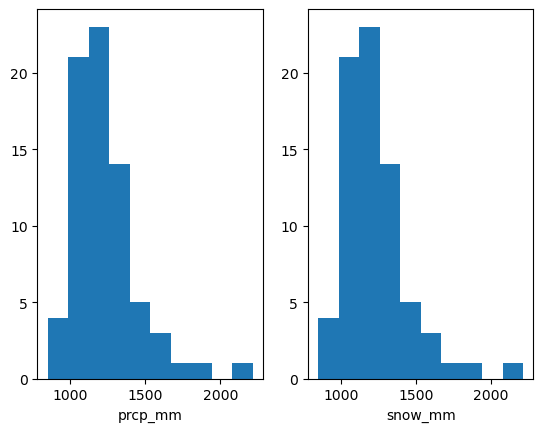

In [483]:
fig, ax = plt.subplots(1,2, squeeze=False)

ax[0,0].hist(prcp_22['norm_prcp_mm_total'])
ax[0,1].hist(prcp_22['norm_prcp_mm_total'])
ax[0,0].set_xlabel('prcp_mm')
ax[0,1].set_xlabel('snow_mm')

plt.show()

That looks a bit better but there are still some extreme values in each. I'll look specifically at the lowest and highest values.

In [484]:
#Create another unique df with my fields in question
unique_updated = prcp_22[['station_id','station_name','reports_#','adj_reports','multi_day_prcp_mm','prcp_mm_22','snow_mm_22','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#Now let's recheck values, this time above 1,500
unique_updated[(unique_updated['norm_prcp_mm_total'] > 1500.0)].sort_values('station_id')

,station_id,station_name,reports_#,adj_reports,multi_day_prcp_mm,prcp_mm_22,snow_mm_22,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
10,WA-KG-143,North Bend 5.4 ESE,364,364,NaN,2216.2,1676.0,6.088462,4.604396,2216.200000,1676.000000
1,WA-KG-263,Lake Forest Park 0.8 SSE,199,199,NaN,1032.0,0.0,3.044384,0.000000,1537.367671,0.000000
67,WA-KG-268,Vashon 0.4 W,210,210,NaN,1139.7,0.0,3.993617,0.060790,1758.710638,0.000000
13,WA-KG-28,Redmond 1.0 N,107,112,41.9,922.5,51.0,2.810685,0.369863,1633.603288,144.575342
8,WA-KG-281,Mercer Island 1.3 SSE,127,127,NaN,911.9,102.0,2.858630,0.230137,1592.253973,156.772603
9,WA-KG-7,North Bend 2.8 SE,312,312,NaN,1486.9,635.0,6.088462,4.604396,1809.588462,879.032967


In [485]:
#how about abnormally low values below the min of our more complete values?
unique_updated[(unique_updated['norm_prcp_mm_total'] < 1000)].sort_values('station_id')

,station_id,station_name,reports_#,adj_reports,multi_day_prcp_mm,prcp_mm_22,snow_mm_22,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
50,WA-KG-196,Des Moines 2.9 S,255,255,NaN,646.7,0.0,3.110685,0.180822,988.875342,0.000000
57,WA-KG-200,Seattle 5.8 SSE,290,290,NaN,669.3,8.0,3.118356,0.104110,903.176712,15.808219
60,WA-KG-204,Seattle 0.9 SSE,314,359,134.9,939.8,0.0,2.617827,0.000000,939.800000,0.000000
45,WA-KG-239,Seattle 3.9 N,317,341,75.9,984.5,0.0,2.887097,0.000000,984.500000,0.000000
46,WA-KG-294,Seattle 4.0 NNW,215,217,3.8,421.9,0.0,2.887097,0.000000,849.190323,0.000000
15,WA-KG-33,Sheridan Beach 3.7 S,353,365,37.3,995.1,104.0,2.726301,0.284932,995.100000,104.000000


There are some low values, but my main concern is on that right tail. Looking at the larger records, I don't think any of these will fit into my future analysis. I'm looking at Seattle Proper, but I have climate data from all of King County Washington. So I won't spend anymore time on fixing these largeer outliers and move onto focusing on Seattle specific data.

##### 3.0.5.6 Drop Columns No Longer Needed

I no longer need the columns that helped me get to my final normalized amounts. So I'll drop those now.

In [486]:
prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'reports_#',
       'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22', 'snow_mm_22',
       'adj_reports', 'nearest_complete', 'station_name_nearest',
       'norm_prcp_daily_avg', 'norm_snow_daily_avg', 'norm_prcp_mm_total',
       'norm_snow_mm_total'],
      dtype='object')

In [487]:
prcp_22.drop(columns=['multi_day_prcp_mm', 'reports_#','md_overlap', 'prcp_mm_22', 'snow_mm_22','nearest_complete', 'station_name_nearest',
       'norm_prcp_daily_avg', 'norm_snow_daily_avg'], inplace=True)

prcp_22.head(3)

,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total
0,WA-KG-3,Lake Forest Park 0.4 W,47.763558,-122.293917,365,1111.200000,0.0
1,WA-KG-263,Lake Forest Park 0.8 SSE,47.751720,-122.279500,199,1537.367671,0.0
2,WA-KG-4,Renton 3.2 E,47.484508,-122.127169,21,1298.664835,0.0


#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Rename Fields

In [488]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [489]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 72
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          73 non-null     object 
 1   station_name        73 non-null     object 
 2   lat_prcp            73 non-null     float64
 3   long_prcp           73 non-null     float64
 4   adj_reports         73 non-null     int64  
 5   norm_prcp_mm_total  73 non-null     float64
 6   norm_snow_mm_total  73 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.6+ KB


In [490]:
#Rename lat-long field in trees data to signify it is from this datasource. I could do this on a merge later, but I like to keep them seperate.
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)

##### 3.1.2 Map the Nearest Station to Each Tree Record

In [491]:
#Using my defined functions to add a field to my trees_data df which will list the ID for the nearest weather station.
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees'],prcp_22), axis=1)

In [492]:
#explore results
trees_data['nearest_station'].value_counts()

 WA-KG-239    16065
 WA-KG-204    12400
 WA-KG-280    11640
 WA-KG-225    11626
 WA-KG-258    11472
 WA-KG-287    10225
 WA-KG-200     9474
 WA-KG-79      8940
 WA-KG-266     8921
 WA-KG-243     8778
 WA-KG-272     8279
 WA-KG-294     6749
 WA-KG-301     6495
 WA-KG-229     4918
 WA-KG-238     4825
 WA-KG-192     4377
 WA-KG-199     4195
 WA-KG-72      2565
 WA-KG-234     2544
 WA-KG-145     2369
 WA-KG-33      1830
 WA-KG-286     1138
 WA-KG-299      796
 WA-KG-297      676
 WA-KG-263      492
 WA-KG-5        236
 WA-KG-81        34
 WA-KG-210       21
Name: nearest_station, dtype: int64

This looks a lot better than the last data source, which only had 3 'nearest' stations. Let's now merge these in and explore a bit more.
##### 3.2.5 Merge Datasets Into a Single Table

In [493]:
#inner join on the station_id to create a master df to continue with my EDA.
trees_prcp_all = pd.merge(trees_data, prcp_22, left_on='nearest_station', right_on='station_id', how='inner')

In [495]:
#check which stations came back, we'll use the station id later to split out for our map
trees_prcp_all[['station_id','station_name']].value_counts()

station_id  station_name            
 WA-KG-239  Seattle 3.9 N               16065
 WA-KG-204  Seattle 0.9 SSE             12400
 WA-KG-280  Seattle 4.6 NNE             11640
 WA-KG-225  Seattle 2.1 ESE             11626
 WA-KG-258  Seattle 6.4 S               11472
 WA-KG-287  Seattle 2.5 SE              10225
 WA-KG-200  Seattle 5.8 SSE              9474
 WA-KG-79   Seattle 3.0 WNW              8940
 WA-KG-266  Seattle 2.9 ENE              8921
 WA-KG-243  Seattle 3.9 SSW              8778
 WA-KG-272  Seattle 4.9 SE               8279
 WA-KG-294  Seattle 4.0 NNW              6749
 WA-KG-301  Seattle 4.8 NNW              6495
 WA-KG-229  Seattle 5.5 NNE              4918
 WA-KG-238  Seattle 5.0 NE               4825
 WA-KG-192  Seattle 5.6 N                4377
 WA-KG-199  Seattle 4.5 N                4195
 WA-KG-72   Seattle 4.2 SW               2565
 WA-KG-234  Matthews Beach 0.4 NW        2544
 WA-KG-145  Seattle 4.2 N                2369
 WA-KG-33   Sheridan Beach 3.7 S         18

In [508]:
#Check how manyunique values of nearest station
len(trees_prcp_all['nearest_station'].unique())

28

##### 3.2.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

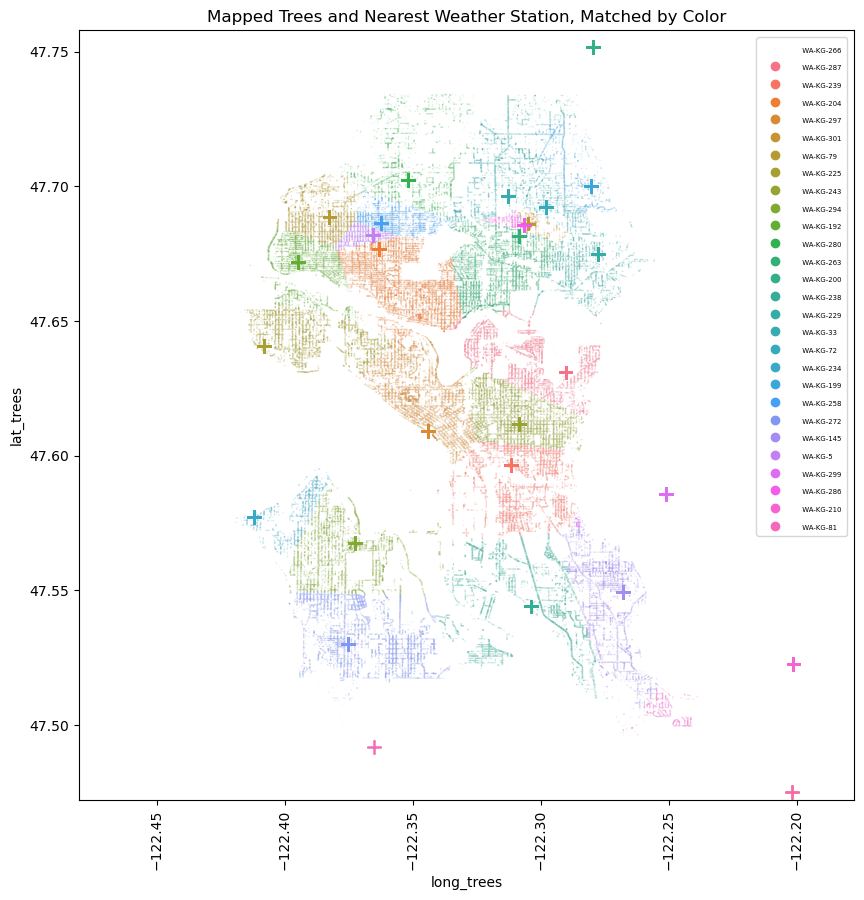

In [507]:
#Create a plot, splitting out the different points by color for their different closest stations and plot them on the same plane as the stations.
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(ax=ax, x='long_trees', y='lat_trees', data=trees_prcp_all, hue='nearest_station', marker='o', s=1, alpha=0.1)
sns.scatterplot(ax=ax, x='long_prcp', y='lat_prcp', data=trees_prcp_all, hue='nearest_station', marker='+', s=100)

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_prcp_all['long_trees'].min()*1.0005, trees_prcp_all['long_trees'].max()*.9995, trees_prcp_all['lat_trees'].min()*0.9995, trees_prcp_all['lat_trees'].max()*1.0005])

#create list for legend
leg_label = trees_prcp_all['nearest_station'].unique()

#set title, change legend font size, and rotate axis labels
ax.set_title('Mapped Trees and Nearest Weather Station, Matched by Color')
plt.legend(leg_label)
plt.setp(ax.get_legend().get_texts(), fontsize='5')
plt.xticks(rotation=90)
plt.show()

**Observations**
\
This isn't the prettiest graph, which such a long legend and no actual underlying map, but it does what I needed and shows the mapping function did work to flag the closest weather station to each tree. There are some some tree-station pair groupings, with the smallest being 26 tree records mapping closest to Burien 2.1 NNW station, I will let these play out as I do more EDA.
\
\
A next question I have is the location to the nearest station. I see some station '+' markers pretty isolated. They may still be the 'closest' but aren't close enough to be fully valuable. We can add another field with distance to the nearest station before moving on to the rest of our more 'traditional' EDA. This will give our data another variable that could prove useful.

##### 3.2.7 Distance Between Points

In [509]:
# Use our handy formula created above on our trees_prcp_all df using list comprehension on each row. This could be a lenghty run so let's see how it goes.

trees_prcp_all['distance_between'] = [dist_b_points(trees_prcp_all.long_trees[i], trees_prcp_all.lat_trees[i]
                                                    , trees_prcp_all.long_prcp[i], trees_prcp_all.lat_prcp[i]) 
                                                    for i in range(len(trees_prcp_all))]

In [510]:
#That actually ran really fast. Let's see how it went.
trees_prcp_all['distance_between'].describe()

count    162080.000000
mean          1.517032
std           0.977325
min           0.004214
25%           0.807316
50%           1.334919
75%           1.988311
max           7.514261
Name: distance_between, dtype: float64

It is a little hard to tell without mapping out a full map, but I know a quarter degree of longitude is around 8.5 miles. Looking at our plot above this appears plausible that the max disstance would be around 7.5km.

In [511]:
#Let's see how that looks in our df
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,0.947927
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,3.367105
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,1.145690


### 3.3 "Traditional" EDA

Now that we have a combined dataframe, let's move on to exploring it further with some fun EDA.

#### 3.3.1 Shape

We've done a lot of work on this, so let's get a reminder of the shape.

In [512]:
trees_prcp_all.shape

(162080, 19)

We're up to 19 fields, and still have all our 160k tree records. Let's keep going.

#### 3.3.2 Data Types and Column Info

In [513]:
trees_prcp_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   long_trees                 162080 non-null  float64
 4   lat_trees                  162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
 10  nearest_station            162080 non-null  object 
 11  station_id                 162080 non-null  object 
 12  station_name               162080 non-null  object 
 13  lat_prcp                   16

We have some missing values in planted_date, most_recent_observation, age_at_obs (expected as this was calculated of the prior two).
\
\
I feel like we will want to impute values for missing ages later but I will update some data types!

In [515]:
#We need to update our data fields to be datetime dtypes
trees_prcp_all['planted_date'] = pd.to_datetime(trees_prcp_all['planted_date'])
trees_prcp_all['most_recent_observation'] = pd.to_datetime(trees_prcp_all['most_recent_observation'])

trees_prcp_all[['planted_date','most_recent_observation']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   planted_date             159111 non-null  datetime64[ns]
 1   most_recent_observation  162075 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.7 MB


#### 3.3.2 Add Unique tree_id field

This may not be totally necessary, but I think it will help me as I continue my EDA to assign each tree a simple unique numerical value.

In [518]:
#add id using index+1 to skip 0 and set the starting point to 1
trees_prcp_all['tree_id'] = trees_data.index+1

#convert this to an object
trees_prcp_all['tree_id'] = trees_prcp_all['tree_id'].astype(object)

In [522]:
#validate these are unique by value counting as taking the first 5 records, since value_counts defaults to sorted greatest to least
trees_prcp_all['tree_id'].value_counts().head(5)

1         1
108057    1
108050    1
108051    1
108052    1
Name: tree_id, dtype: int64

#### 3.3.2 Check for Duplicates

Duplicates may be realistic if two trees are planted next to eachother on the same date, but let's see if we find any.

In [523]:
duplicates = trees_prcp_all.duplicated()
duplicated_records = trees_prcp_all[duplicates].sort_values('tree_id')

duplicated_records

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,tree_id


Nice! No exact duplicates

#### 3.5.2 Visualize Distributions

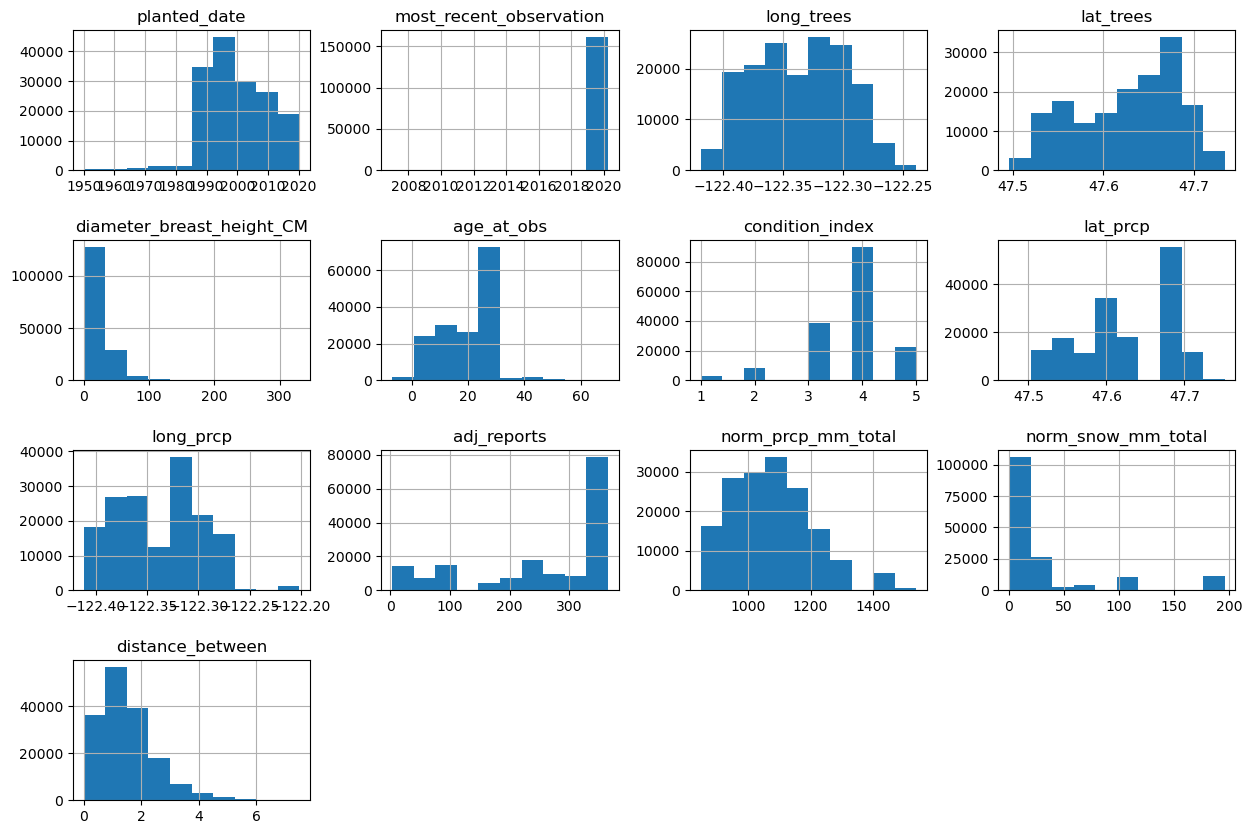

In [524]:
#Histograms
trees_prcp_all.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

**Observations:**
- Planted_date: There is a big jump in the 90s. It's possible there is an older section of the city that wasn't mapped with tree records, but the plot of trees looked pretty widely spread and the lat, lon above fits with the general area of the city. So for now I won't do anything.
- Diameter_breast_height_cm: There is likely a large record out to the right, so we'll need to check that out.
- Condition_index: Not many 1s and 2s. So we'll have to apply some steps in preprocessing to deal with this imbalance.
- Reports_# & Adj_reports: More shifted into that complete 365 window, making me think a lot of our trees are in the area that was just a few short.
- Distance_between: Most of are trees were fairly close to our nearest station data point.
- Precipitation & Snow Fields: Our largest outlier is gone, but it will still be worth looking again at the larger amounts now that we've filtered out the station outside of our scope of data.

#### 3.5.3 Explore Diameter Field

It looks like there may be some outliers here.

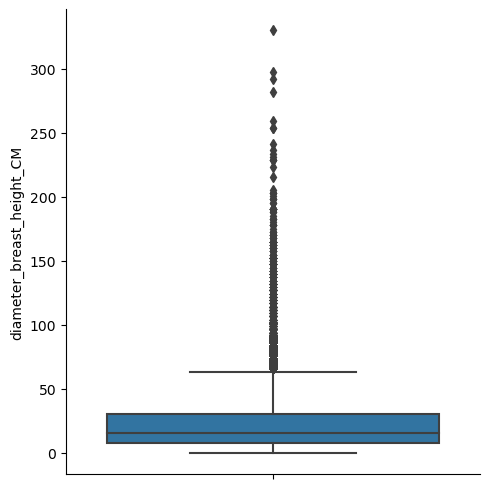

count    162080.000000
mean         21.514417
std          18.640934
min           0.000000
25%           7.620000
50%          15.240000
75%          30.480000
max         330.200000
Name: diameter_breast_height_CM, dtype: float64


In [526]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_prcp_all, kind="box")

plt.show()

print(trees_prcp_all['diameter_breast_height_CM'].describe())

In [527]:
#filter down to values > 1.5x the IQR
outliers = trees_prcp_all[trees_prcp_all['diameter_breast_height_CM'] > 30.48*1.5]

#display largest value of each tree
outliers.groupby('common_name').max('diameter_breast_height_CM').sort_values('diameter_breast_height_CM', ascending=False)['diameter_breast_height_CM']

common_name
Quaking aspen                       330.20
Giant sequoia                       297.18
Portugal laurel                     292.10
Bigleaf maple                       259.08
Port orford cedar lawson cypress    254.00
                                     ...  
Tatarian maple                       48.26
Swamp white oak                      48.26
Smooth sumac                         48.26
Sterling linden                      48.26
Autumn gold ginkgo                   48.26
Name: diameter_breast_height_CM, Length: 326, dtype: float64

We have 326 species with atleast one record over 1.5x the IQR. Breast height diameter is simply the diameter of the tree (width) at breast height. Not specifically the trunk, but reach of the tree. This could vary greatly for specifc trees, so I think it will be best to expand our view to see records which are beyond the typical range for a grouping of that species.
\
\
For consistency, I will consider a record an outlier if it is 1.5x the IQR.

In [547]:
#define function to establish what is an outlier
def get_outliers(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3-q1
    lower_threshold = q1 - (1.5*iqr)
    upper_threshold = q3 + (1.5*iqr)
    return sum((col<lower_threshold) | (col>upper_threshold))

In [548]:
outliers_by_group = trees_prcp_all.groupby('common_name')['diameter_breast_height_CM'].agg([get_outliers]).sort_values('get_outliers', ascending=False)

print(outliers_by_group)
print(outliers_by_group['get_outliers'].sum())

                                get_outliers
common_name                                 
Eddie's white wonder dogwood             153
American hornbeam                        150
(smooth) japanese maple                  117
Norway maple                             116
Autumn brilliance serviceberry            95
...                                      ...
New horizon elm                            0
Net leaf oak                               0
Myrtle california wax                      0
Chancelor littleleaf linden                0
Judas tree                                 0

[705 rows x 1 columns]
4537


According to that formula, Eddie's white wonder dogwood produced 153 outliers within it's own grouping. Let's explore the distribution for this one specifically.

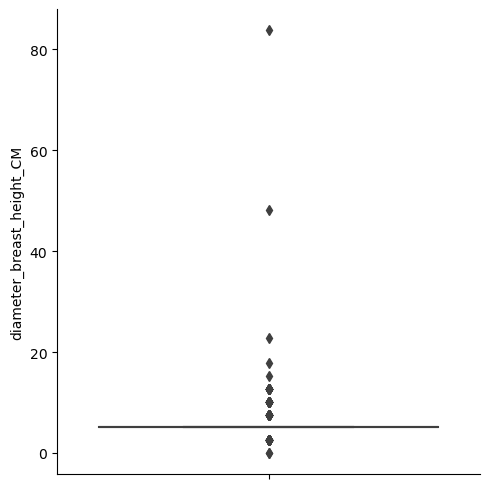

count    408.000000
mean       6.188137
std        5.197746
min        0.000000
25%        5.080000
50%        5.080000
75%        5.080000
max       83.820000
Name: diameter_breast_height_CM, dtype: float64


In [549]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"], kind="box")

plt.show()

print(trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"]['diameter_breast_height_CM'].describe())

In [550]:
#it looks like there is a really big cluster at the same diameter, let's see the value counts.
trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"]['diameter_breast_height_CM'].value_counts()

5.08     255
2.54      54
7.62      36
10.16     32
12.70     24
0.00       2
17.78      1
22.86      1
48.26      1
83.82      1
15.24      1
Name: diameter_breast_height_CM, dtype: int64

This is likely some generalization in the measurement, vs. 255 measured example at 5.08 centimeters. In total our calculation found 4,537 in-group outliers. That is less than 3% of our total dataset. Because it's such a small subset, I'm comfortable dropping our "outliers". I do wonder if there is a why I can make the dropping dynamic and only use the 1.5x IQR if the IQR is > 0 to avoid dropping records like we have for Eddie's Dogwood that are valid, but ouside of the 0 IQR.

#### 3.5.4 Drop Diameter Outliers

I think I'll actually go a bit manual and add the statistics to the data frame and then drop using a filter clause of some sort.

##### 3.5.4.1 Calculate Limits

In [573]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [589]:
#create summary statistics in a dataframe for each common_name gourping
df2 = (trees_prcp_all.groupby('common_name')
             .agg(Count=('diameter_breast_height_CM', 'count'),    
                  Mean=('diameter_breast_height_CM','mean'),
                  StDv=('diameter_breast_height_CM', 'std'),        
                  P25= ('diameter_breast_height_CM',percentile(25)), #This is for first quartile
                  P50= ('diameter_breast_height_CM',percentile(50)), #2nd Quartile
                  P75= ('diameter_breast_height_CM',percentile(75)),
                  )) #This is for Quartile 3

In [592]:
#calculate upper and lower outlier limits based on 1. 1.5X the IQR and 2. 3 STDEVs from the mean
df2['IQR'] = (df2['P75']-df2['P25'])
df2['lower_a'] = df2['P25'] - (df2['IQR']*1.5)
df2['upper_a'] = df2['P75'] + (df2['IQR']*1.5)
df2['lower_b'] = df2['Mean'] - (df2['StDv']*3)
df2['upper_b'] = df2['Mean'] + (df2['StDv']*3)

df2.head()

,Count,Mean,StDv,P25,P50,P75,IQR,lower_a,upper_a,lower_b,upper_b
common_name,,,,,,,,,,,
(american) arborvitae,603,17.573599,15.765731,7.620,12.70,20.32,12.700,-11.4300,39.3700,-29.723594,64.870791
(arnold) tulip tree,65,10.550769,7.257230,5.080,7.62,12.70,7.620,-6.3500,24.1300,-11.220921,32.322459
(california) incense cedar,220,29.267727,19.684401,14.605,27.94,40.64,26.035,-24.4475,79.6925,-29.785474,88.320929
(common) goldenchain,216,16.251296,8.997380,10.160,15.24,20.32,10.160,-5.0800,35.5600,-10.740845,43.243438
(european) bird cherry,21,22.013333,13.662587,12.700,17.78,30.48,17.780,-13.9700,57.1500,-18.974429,63.001095


##### 3.5.4.2 Merge Limits into Main DataFrame

In [595]:
trees_stats = pd.merge(trees_prcp_all, df2, on='common_name', how='left', suffixes=("", '_stats'))

trees_stats.head()

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,Mean,StDv,P25,P50,P75,IQR,lower_a,upper_a,lower_b,upper_b
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,30.539531,14.880132,20.32,30.48,38.10,17.78,-6.35,64.77,-14.100865,75.179928
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,24.325238,14.743777,12.70,22.86,33.02,20.32,-17.78,63.50,-19.906092,68.556569
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,9.593424,5.650118,5.08,7.62,12.70,7.62,-6.35,24.13,-7.356929,26.543777
3,1991-07-17,2019-04-27,Carriere (lavallei) hawthorn,-122.281439,47.630559,38.10,good,no_info,27.778804,4.0,...,16.948507,9.378874,10.16,15.24,22.86,12.70,-8.89,41.91,-11.188114,45.085128
4,1991-07-16,2019-04-27,Evergreen (southern) magnolia,-122.282837,47.627876,15.24,fair,introduced,27.781542,3.0,...,14.438071,9.985277,7.62,12.70,20.32,12.70,-11.43,39.37,-15.517758,44.393901


##### 3.5.4.3 Flag As Outlier or Not

In [626]:
#add outlier column using where clause that checks 1.5X the IQR if the IQR > 0. If it's not > 0 then it uses > 3 standard devaiations from the mean.
trees_stats['outlier'] = np.where((trees_stats['IQR'] > 0), ~trees_stats['diameter_breast_height_CM'].between(trees_stats['lower_a'], trees_stats['upper_a']), ~trees_stats['diameter_breast_height_CM'].between(trees_stats['lower_b'], trees_stats['upper_b']))
#now overwrite NaN values to not count as outliers
trees_stats['outlier'] = np.where((trees_stats['IQR'].isna()),'NoData', trees_stats['outlier'])

##### 3.5.4.4 Drop Outliers and Unecessary Fields

In [644]:
#create new dataframe by filtering out outlier columns equal to 'True'
outliers = trees_stats['outlier'] == 'True'
trees_climate = trees_stats[~outliers]

In [645]:
trees_climate.columns

Index(['planted_date', 'most_recent_observation', 'common_name', 'long_trees',
       'lat_trees', 'diameter_breast_height_CM', 'condition', 'native',
       'age_at_obs', 'condition_index', 'nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'adj_reports',
       'norm_prcp_mm_total', 'norm_snow_mm_total', 'distance_between',
       'tree_id', 'Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',
       'lower_a', 'upper_a', 'lower_b', 'upper_b', 'outlier'],
      dtype='object')

In [646]:
trees_climate.drop(columns=['Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',
       'lower_a', 'upper_a', 'lower_b', 'upper_b', 'outlier'], inplace=True)

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_8511/1321155297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_climate.drop(columns=['Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',


In [647]:
trees_climate.columns

Index(['planted_date', 'most_recent_observation', 'common_name', 'long_trees',
       'lat_trees', 'diameter_breast_height_CM', 'condition', 'native',
       'age_at_obs', 'condition_index', 'nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'adj_reports',
       'norm_prcp_mm_total', 'norm_snow_mm_total', 'distance_between',
       'tree_id'],
      dtype='object')

#### 3.5.5 Validate Normalized/Imputed Precipitation and Snow Numbers

In [58]:
#First, I'll check the summary stats of our more "complete" stations to get a good sense of where most values will likely lie.
prcp_subset['prcp_mm_22'].describe()

count      12.000000
mean     1039.700000
std        67.255429
min       939.800000
25%       992.450000
50%      1036.850000
75%      1094.725000
max      1138.200000
Name: prcp_mm_22, dtype: float64

In [59]:
#now I'll look at stations which didn't have a more complete dataset and are greater than the 75th percentile of the above subset
trees_climate_unique = trees_climate[['station_id','reports_#','adj_reports','station_id_norm','prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#there are some pesky '\xa0' text before my station_id fields. This will remove that.
trees_climate_unique['station_id'] = trees_climate_unique['station_id'].str.split().str.join(' ')

trees_climate_normalized = trees_climate_unique[(trees_climate_unique['reports_#'] < 300) & (trees_climate_unique['norm_prcp_mm_total'] > 1094.725)].sort_values('station_id')

I have some limited ability to searched daily data for stations, so I'll do a manual look online here: https://merbgai.cocorahs.org/ViewData/StationPrecipSummary.aspx
\
\
**Observations:**
These largely look like unexpected amounts of multi-reported days. Here are the differences between manually counted and estimated reported days.
- WA-KG-287: Manually calculated 309, estimated 245.
- WA-KG-280: Manually calculated 110, estimated 52.
- WA-KG-192: Manually calculated 172, estimated 127.
- WA-KG-297: Manually calculated 90, estimated 63.
- WA-KG-263: Manually calculated 199, estimated 207. Pretty close, I'll leave.
- WA-KG-210: Manually calculated 365, estimated 222.
- WA-KG-301: Manually calculated 66, estimated 54.

##### 3.5.4.1 Re-Calculate Normalized Numbers

I'll update the adj_reports field for these 7 and then reclaculate the normalized amounts.

In [60]:
#create a dictionary of updated record counts to add back into our dataframe
manual_report_count = {245: 309, #'WA-KG-287'
52: 110, #'WA-KG-280'
127: 172, #'WA-KG-192'
63: 90, #'WA-KG-297'
222: 365, #'WA-KG-210'
54: 66 #'WA-KG-301'
}

In [61]:
#test replacement of values on a smaller df - create new dataframe
test_df = trees_climate_normalized[trees_climate_normalized['station_id'].isin(trees_climate_normalized['station_id'].unique())]

test_df

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
72786,WA-KG-192,122,127,WA-KG-239,898.9,71.0,2.983333,0.000000,1431.425000,71.000000
123691,WA-KG-192,122,127,WA-KG-229,898.9,71.0,3.178655,0.000000,1466.289912,71.000000
158699,WA-KG-210,213,222,WA-KG-258,997.2,0.0,3.252000,0.108571,1345.977000,0.000000
128433,WA-KG-263,199,207,WA-KG-229,1032.0,0.0,3.178655,0.000000,1408.670614,0.000000
158720,WA-KG-263,199,207,WA-KG-234,1032.0,0.0,3.064516,0.000000,1395.145161,0.000000
27595,WA-KG-280,50,52,WA-KG-238,444.8,0.0,3.002041,0.072886,1149.529082,0.000000
74398,WA-KG-280,50,52,WA-KG-239,444.8,0.0,2.983333,0.000000,1145.137500,0.000000
126456,WA-KG-280,50,52,WA-KG-229,444.8,0.0,3.178655,0.000000,1190.989254,0.000000
8131,WA-KG-287,236,245,WA-KG-225,1138.7,35.0,3.061918,0.536986,1414.272603,83.328767
84473,WA-KG-287,236,245,WA-KG-272,1138.7,35.0,3.020192,0.000000,1410.517308,35.000000


In [62]:
#replace old adj_reports values with manually counted values .replace()
trees_climate['adj_reports'] = trees_climate['adj_reports'].replace(manual_report_count)

#validate results
trees_climate[['station_id','adj_reports']].value_counts()

station_id  adj_reports
 WA-KG-239  330            16065
 WA-KG-204  327            12400
 WA-KG-280  110            11640
 WA-KG-225  365            11625
 WA-KG-258  350            11472
 WA-KG-287  309            10224
 WA-KG-200  302             9474
 WA-KG-79   233             8940
 WA-KG-266  246             8921
 WA-KG-243  3               8778
 WA-KG-272  312             8279
 WA-KG-294  224             6749
 WA-KG-301  66              6495
 WA-KG-229  342             4918
 WA-KG-238  343             4825
 WA-KG-192  172             4377
 WA-KG-199  17              4194
 WA-KG-72   356             2565
 WA-KG-234  341             2544
 WA-KG-145  93              2369
 WA-KG-33   365             1830
 WA-KG-286  32              1138
 WA-KG-299  90               796
 WA-KG-297  90               676
 WA-KG-263  207              492
 WA-KG-5    365              236
 WA-KG-81   365               34
 WA-KG-210  365               21
dtype: int64

In [63]:
#Now that my adj_report numbers are updated, I'll re-do my calculated 'total' fields under the new assumptions
#But first, will all these changes, let's update to a new replicated df
trees_climate_updated = trees_climate.reset_index(drop=True)

#Let's again remove the excess text if it is there
trees_climate_updated['station_id'] = trees_climate_updated['station_id'].str.split().str.join(' ')

print(trees_climate.shape)
print(trees_climate_updated.shape)

(162077, 28)
(162077, 28)


In [64]:
#reuse my formulas from above
trees_climate_updated['norm_prcp_mm_total'] = trees_climate_updated['prcp_mm_22'] + ((365-trees_climate_updated['adj_reports'])*trees_climate_updated['norm_prcp_daily_avg']*0.75)

#fill in missing days with daily avg prcp from our nearest "complete" station
trees_climate_updated['norm_snow_mm_total'] = np.where(trees_climate_updated['daily_snow_mm'] > 0, trees_climate_updated['daily_snow_mm'] + ((365-trees_climate_updated['adj_reports'])*trees_climate_updated['norm_snow_daily_avg']*0.75), trees_climate_updated['daily_snow_mm'])

In [65]:
#Create another unique df with my fields in question
unique_updated = trees_climate_updated[['station_id','reports_#','adj_reports','station_id_norm','prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#Now let's recheck values, this time above 1,200
unique_updated[(unique_updated['reports_#'] < 300) & (unique_updated['norm_prcp_mm_total'] > 1200.0)].sort_values('station_id')

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
72784,WA-KG-192,122,172,WA-KG-239,898.9,71.0,2.983333,0.000000,1330.737500,71.000000
123688,WA-KG-192,122,172,WA-KG-229,898.9,71.0,3.178655,0.000000,1359.010307,71.000000
128430,WA-KG-263,199,207,WA-KG-229,1032.0,0.0,3.178655,0.000000,1408.670614,0.000000
158717,WA-KG-263,199,207,WA-KG-234,1032.0,0.0,3.064516,0.000000,1395.145161,0.000000
8131,WA-KG-287,236,309,WA-KG-225,1138.7,35.0,3.061918,0.536986,1267.300548,57.553425
84470,WA-KG-287,236,309,WA-KG-272,1138.7,35.0,3.020192,0.000000,1265.548077,35.000000
101513,WA-KG-287,236,309,WA-KG-5,1138.7,35.0,2.858630,0.230137,1258.762466,44.665753
102779,WA-KG-287,236,309,WA-KG-204,1138.7,35.0,2.874006,0.000000,1259.408257,35.000000


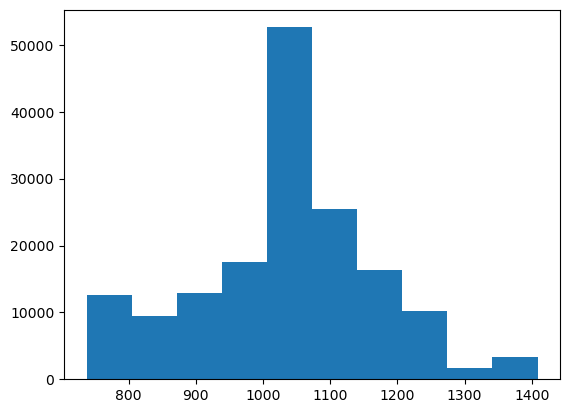

In [66]:
#With those updated, let's take a look at our distribution of precipitation
plt.hist(trees_climate_updated['norm_prcp_mm_total'])
plt.show()

In [67]:
#how about abnormally low values below the min of our more complete values?
unique_updated[(unique_updated['reports_#'] < 300) & (unique_updated['norm_prcp_mm_total'] < 939.0)].sort_values('station_id')

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
85172,WA-KG-200,290,302,WA-KG-272,669.3,8.0,3.020192,0.000000,812.004087,8.000000
118688,WA-KG-200,290,302,WA-KG-204,669.3,8.0,2.874006,0.000000,805.096789,8.000000
145247,WA-KG-200,290,302,WA-KG-258,669.3,8.0,3.252000,0.108571,822.957000,13.130000
118498,WA-KG-243,3,3,WA-KG-204,0.0,48.0,2.874006,0.000000,780.292661,48.000000
134094,WA-KG-243,3,3,WA-KG-72,0.0,48.0,2.894101,0.143258,785.748455,86.894663
142273,WA-KG-243,3,3,WA-KG-258,0.0,48.0,3.252000,0.108571,882.918000,77.477143
100868,WA-KG-286,31,32,WA-KG-272,181.6,0.0,3.020192,0.000000,935.893029,0.000000
66035,WA-KG-294,215,224,WA-KG-239,421.9,0.0,2.983333,0.000000,737.387500,0.000000
123358,WA-KG-299,61,90,WA-KG-33,369.3,0.0,2.726301,0.284932,931.599658,0.000000
59193,WA-KG-79,224,233,WA-KG-239,638.8,13.0,2.983333,0.000000,934.150000,13.000000


In [68]:
#I don't want to mess with the data too much, but I did a 25% adjustment (75% adj factor) on my imputation based on the assumption that days are more likely to be tracked when there is rain, than when there isn't.
#But this breaks down for station WA-KG-243 which had 3 days and 0 rainfall tracked. For this one I will simply imput new values

target_station = 'WA-KG-243' #set this up for locating which records to update
prcp_median = trees_climate_updated['norm_prcp_mm_total'].median() #using median here since each location will have data and this will normalize it better

trees_climate_updated.loc[trees_climate_updated.station_id == target_station, 'norm_prcp_mm_total'] = prcp_median


In [69]:
#validate that stuck
trees_climate_updated[trees_climate_updated['station_id'] == target_station][['station_id','norm_prcp_mm_total']].value_counts()

station_id  norm_prcp_mm_total
WA-KG-243   1062.352644           8778
dtype: int64

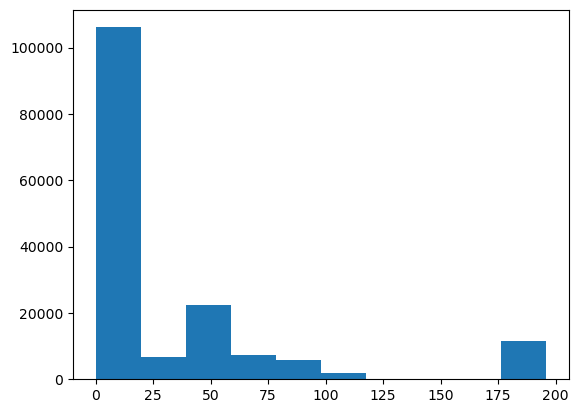

In [70]:
#Last distribution check - this time on our snowfall
plt.hist(trees_climate_updated['norm_snow_mm_total'])
plt.show()


In [71]:
#We'll go through the same process as with our prcp
unique_updated[(unique_updated['reports_#'] < 400) & (unique_updated['norm_snow_mm_total'] > 100)].sort_values('station_id') #filter down to view records

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
15402,WA-KG-225,356,365,WA-KG-225,1117.6,196.0,3.061918,0.536986,1117.6,196.0
121528,WA-KG-33,353,365,WA-KG-33,995.1,104.0,2.726301,0.284932,995.1,104.0


This is actually directly from our reported data. Doing some quick searches online at these location and verifying the data pull I can't find any proof this is incorrect. I will leave for now atleast.

#### 3.5.5 Clean-up Columns

With my imputed values in place, I can drop remaining columns we'll no longer need.

In [72]:
trees_climate_updated.shape

(162077, 28)

In [73]:
#drop all created specifically from our imputing process
trees_climate_updated.drop(columns=['prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','nearest_complete','station_id_norm','norm_station_name'],inplace=True)

trees_climate_updated.shape

(162077, 21)

#### 3.5.5 Check Correlation/Covariance

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_2073/4034685785.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = trees_climate_updated.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon


[]

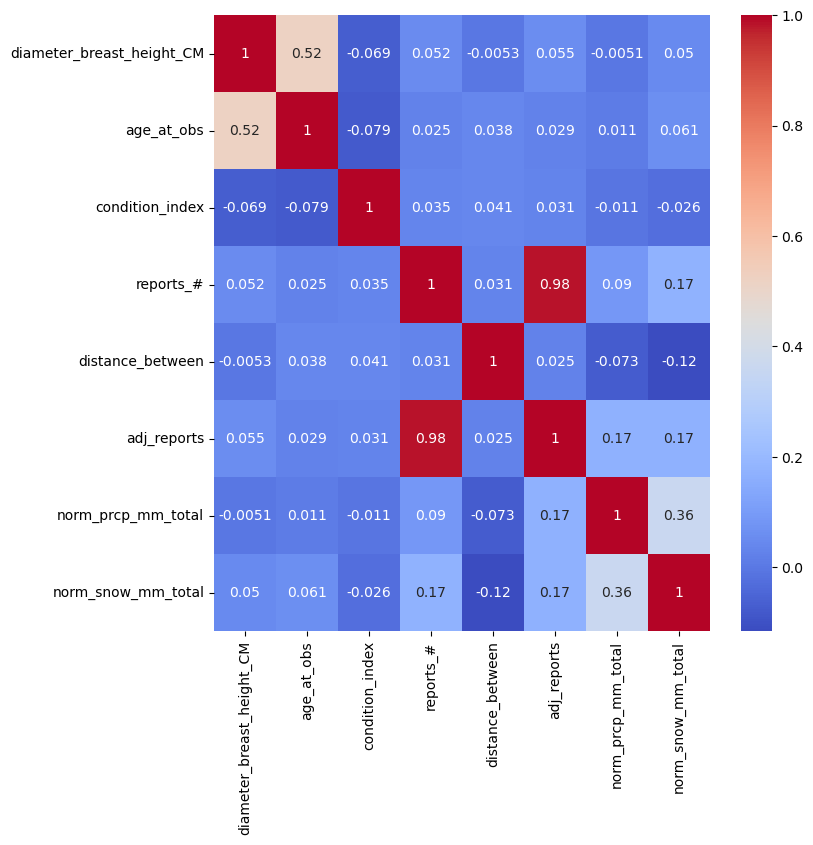

In [74]:
#create variable with values
corrMatrix = trees_climate_updated.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon

fig, ax = plt.subplots(figsize=(8,8))

#plot with seaborn
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')

plt.plot()

**Observations:**
\
Well, not a lot of correlation there. Ouch. I'll continue to move forward and plan on using some categorical fields and some non-linear regressions. So we'll see what we can come up with, but this was not totally unexpected when we pivoted from aiming for using this data to predict surface temperature or air quality to having my target feature come out of the trees data itself.
\
\
It does flow with what I would expect that there is some correlation between age and diameter, that makes me feel better about the quality of data itself. Same with some slight correlation between precipitation and snow fall. # of reports and adjusted reports are expectedlty very correlated, and if we do find some use for one, I'll drop the other in the next step. But I think calculating a daily average either reported or off of the imputed annual total will be my move.
\
\
On to the next!

### 3.6 Save Data

In [75]:
# save trees data to a new csv
filepath = '../data/data_outputs/seattle_trees_explored.csv'
trees_climate_updated.to_csv(filepath, index=False)